## Data Project from 23andMe

### Assignment

Please answer the questions below based on the data provided:

1. Plot daily sales for all 50 weeks.
2. It looks like there has been a sudden change in daily sales. What date did it occur?
3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
5. Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM - 12:00PM), afternoon (12:00PM - 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?


## Question 1
#### Plot daily sales for all 50 weeks

In [101]:
# import libraries 
import pandas as pd
from matplotlib import pyplot as plt 
import glob

In [102]:
# assign a constant figure size and use it in plotting to make plots larger
FIG_SIZE = (8,6)

In [103]:
# get all filenames under the data directory 
l = [pd.read_csv(filename) for filename in glob.glob("./data/*.csv")]

# check the list size to understand how many files will be read
# should be equal to 50
print(len(l))

#  create the dataset using all files under the data directory
df = pd.concat(l, axis=0)
df.head()

50


,sale_time,purchaser_gender
0,2013-01-07 02:14:07,female
1,2013-01-07 02:57:53,male
2,2013-01-07 02:59:49,female
3,2013-01-07 03:02:53,male
4,2013-01-07 03:27:36,female


To extract the sale day (year - month - day) from a complete timestamp (year - month - day hour-second-millisecond) we need to convert the column datatype to DateTime. Pandas library provides several functions to conveniently manipulate timestamps.

In [104]:
sale_day = pd.to_datetime(df['sale_time'])

Now, we can get the day by flooring the timestamp to the closest day. After that, we will group the sales entries by days with the groupby( ) function. Then we will count the entries in each group (which are the sale days in our case) with size( ), which gives us the sales amount for each day. Groupby objects use the given column as an index. As the last step, we will reformat the dataset with the _resetindex( ) function to get rid of sales day indexes.

In [105]:
daily_sales_df = sale_day.groupby(sale_day.dt.floor('d')).size().reset_index(name='sales_amount')
daily_sales_df.rename(columns={'sale_time':'sale_day'},inplace=True)
daily_sales_df.head()

,sale_day,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


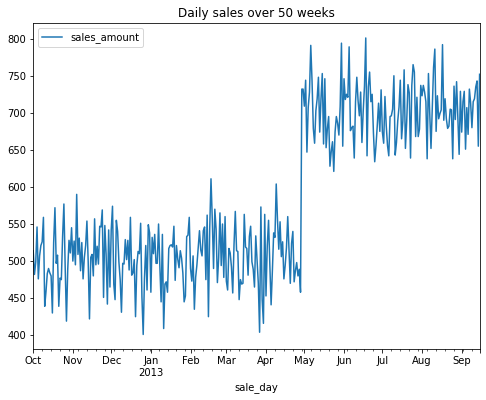

In [106]:
#  to use index in plotting make sale_day index
daily_sales_df.index = daily_sales_df['sale_day']
daily_sales_df.drop(columns=['sale_day'], inplace=True)

#  plot daily sales for all 50 weeks
daily_sales_df.plot(figsize=FIG_SIZE, title = "Daily sales over 50 weeks")
plt.show()

## Question 2

#### It looks like there has been a sudden change in daily sales. What date did it occur?

In [107]:
# compare sales amount difference with the previous day and find the biggest difference 
# which should give the sudden change in the plot
daily_sales_df['prev_day_sale_amount'] = [None] + daily_sales_df['sales_amount'].to_list()[:-1]
daily_sales_df['difference_btw_prev_day'] = daily_sales_df['sales_amount'] - daily_sales_df['prev_day_sale_amount']
daily_sales_df.head()

,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


In [108]:
# get the index of max change to answer what date did it occur
print(daily_sales_df['difference_btw_prev_day'].idxmax())
daily_sales_df[daily_sales_df.index == '2013-04-29']

2013-04-29 00:00:00


,sales_amount,prev_day_sale_amount,difference_btw_prev_day
sale_day,,,
2013-04-29,732,458.0,274.0


## Question 3

#### Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [109]:
# scipy.stats include a function to do t-test and obtain p-value
from scipy import stats

# first drop all nan values (if any) for the test 
daily_sales_df.dropna(inplace=True)

# then compare the max change with all sales_amount column 
# to understand its statistical importance
stats.ttest_1samp(daily_sales_df['sales_amount'], 732)

Ttest_1sampResult(statistic=-26.273266340051002, pvalue=1.3019593251472396e-84)

The obtained p-value as the result of the t-test is 1.3019593251472396e-84 which is lower than 0.05 (we can assume the threshold as 0.05 as common practice). It leads to decide this particular date is important for us.

## Question 4

#### Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [110]:
# create gender_portions_df to analyze sales distribution over genders
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
gender_portions_df = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')

In [111]:
gender_portions_df

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


In [112]:
# calculate female and male sales amount separately
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(),columns=['sale_day'])
new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)
new_df[-5:]

,sale_day,female_sales_amount,male_sales_amount
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462
349,2013-09-15,230,522


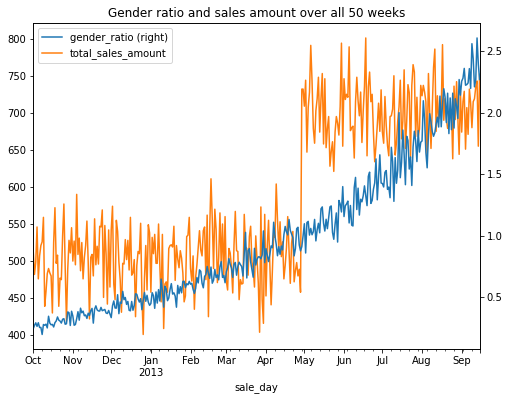

In [113]:
# calculate gender ratio of sales
new_df['gender_ratio'] = new_df['male_sales_amount']/new_df['female_sales_amount']

# plot gender ratio change over 50 weeks with the total sales amount
# observe if there is a correlation between them
plot_df = new_df.copy()
plot_df['total_sales_amount']  = plot_df['male_sales_amount'] + plot_df['female_sales_amount']
plot_df.drop(columns=['female_sales_amount', 'male_sales_amount'], inplace=True)
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['sale_day'], inplace=True)
plot_df.plot(secondary_y = ['gender_ratio'],figsize=FIG_SIZE, title= "Gender ratio and sales amount over all 50 weeks")
plt.show()

The increasing trend of the male ratio in the sales amount does not explain the sudden change. The reason should be something different. For example, it might be caused by starting a new marketing campaign or adding a new feature to the website.

## Question 5

#### Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?

In [114]:
# extract sale hour to divide sales to the part of days
df['sale_hour']  = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour
df.dtypes

sale_time                   object
purchaser_gender            object
sale_day            datetime64[ns]
sale_hour                    int64
dtype: object

In [115]:
# define a function to apply sale hour column to decide a part of day based on the mentioned logic
def assign_day_part(sale_hour):
    """Assign labels based on sale hour."""
    if sale_hour > 6 and sale_hour < 12:
        return 'morning'
    if sale_hour > 12 and sale_hour < 18:
        return 'afternoon'
    if sale_hour > 18 and sale_hour < 24:
        return 'evening'
    if sale_hour > -1 and sale_hour < 6:
        return 'night'

In [116]:
# apply the defined function and create day_part column
df['day_part'] = df['sale_hour'].apply(assign_day_part)

# drop unnecessary columns
df.drop(columns = ['purchaser_gender', 'sale_hour', 'sale_time'], inplace= True)

In [117]:
# calculate sales amount per day part
df_pct_sales = df.groupby(df.day_part).size().reset_index(name='day_part_sales_amount')

# calculate sales amount percentage per day part
df_pct_sales['day_part_sales_percentage'] = df_pct_sales['day_part_sales_amount'] / df_pct_sales['day_part_sales_amount'].sum()

In [118]:
df_pct_sales

,day_part,day_part_sales_amount,day_part_sales_percentage
0,afternoon,68119,0.394595
1,evening,41111,0.238145
2,morning,49833,0.288669
3,night,13567,0.078590
